# VQE on the Kagome Unit Cell

**NOTE: python3.10 required**

Due to the rotational symmetry of a single unit cell of the Kagome lattice, one good solution is as follows.

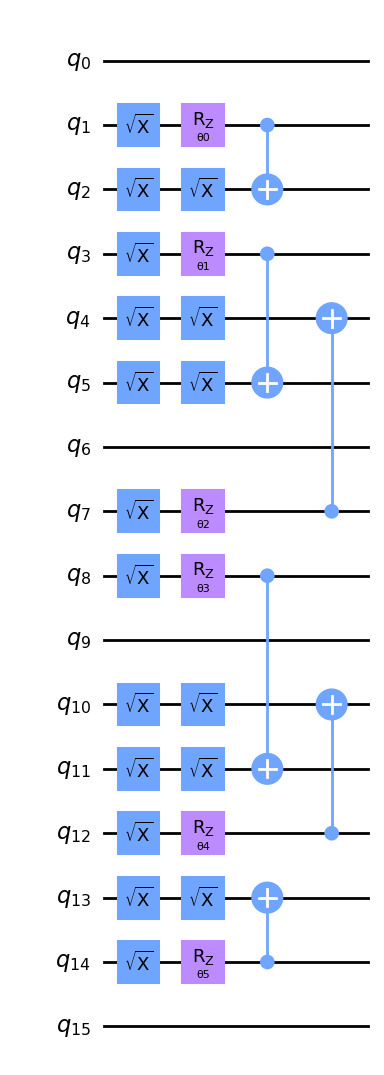

In [1]:
import numpy as np
from kagomevqe import (
    GuadalupeKagomeExtended16,
    GuadalupeKagomeRotationalSymmetry,
    KagomeHamiltonian,
)
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_ibm_runtime import Estimator, Session

ansatz = GuadalupeKagomeRotationalSymmetry()
ansatz.draw('mpl')

In [2]:

x0 = [-np.pi/2] * ansatz.num_parameters

with Session(backend="ibmq_qasm_simulator") as session:
	estimator = Estimator(session=session)
	vqe = VQE(estimator, ansatz, L_BFGS_B(), initial_point=x0)
	result = vqe.compute_minimum_eigenvalue(KagomeHamiltonian.pauli_sum_op())
	print(result)



{   'aux_operators_evaluated': None,
    'cost_function_evals': 7,
    'eigenvalue': -18.0,
    'optimal_circuit': <kagomevqe.ansatze.GuadalupeKagomeRotationalSymmetry object at 0x12e938400>,
    'optimal_parameters': {   Parameter(θ0): -1.5707963267948966,
                              Parameter(θ1): -1.5707963267948966,
                              Parameter(θ2): -1.5707963267948966,
                              Parameter(θ3): -1.5707963267948966,
                              Parameter(θ4): -1.5707963267948966,
                              Parameter(θ5): -1.5707963267948966},
    'optimal_point': array([-1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633,
       -1.57079633]),
    'optimal_value': -18.0,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x12e86da20>,
    'optimizer_time': 43.19862508773804}


However, this doesn't necessarily scale well to extensions of the lattice without that symmetry.

Here is one possible extension of the Kagome lattice using all 16 of Guadalupe's qubits.

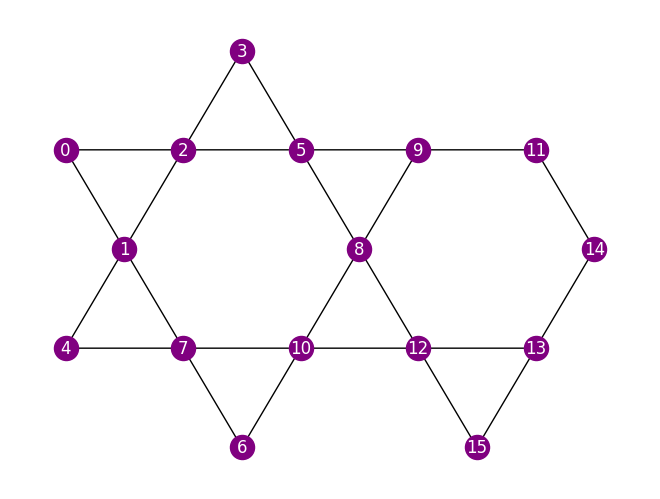

In [3]:
from kagomevqe import Kagome16AsymmetricHamiltonian

extended_lattice = Kagome16AsymmetricHamiltonian.lattice()
kagome_pos = {
    0: [0, -1],
    1: [0.5, -2],
    2: [1, -1],
    3: [1.5, 0],
    4: [0, -3],
    5: [2, -1],
    6: [1.5, -4],
    7: [1, -3],
    8: [2.5, -2],
    9: [3, -1],
    10: [2, -3],
    11: [4, -1],
    12: [3, -3],
    13: [4, -3],
    14: [4.5, -2],
    15: [3.5, -4],
}
style = {
    "with_labels": True,
    "font_color": "white",
    "node_color": "purple",
    "pos": kagome_pos,
}
extended_lattice.draw(style=style)  # type: ignore

In [4]:
ham = Kagome16AsymmetricHamiltonian.pauli_sum_op()
ansatz = GuadalupeKagomeExtended16()
x0 = [-np.pi/2] * ansatz.num_parameters

with Session(backend="ibmq_qasm_simulator") as session:
	estimator = Estimator(session=session)
	vqe = VQE(estimator, ansatz, L_BFGS_B(), initial_point=x0)
	result = vqe.compute_minimum_eigenvalue(ham)
	print(result)


{   'aux_operators_evaluated': None,
    'cost_function_evals': 207,
    'eigenvalue': -23.961999999999996,
    'optimal_circuit': <kagomevqe.ansatze.GuadalupeKagomeExtended16 object at 0x12ebba0e0>,
    'optimal_parameters': {   Parameter(θ1): -1.5707964353761135,
                              Parameter(θ0): -1.570796547059651,
                              Parameter(θ6): -1.570796661845509,
                              Parameter(θ5): -1.5707962895670506,
                              Parameter(θ2): -1.570796143757988,
                              Parameter(θ4): -1.5707964974225233,
                              Parameter(θ3): -1.5707960724046168,
                              Parameter(θ7): -1.5707963081809737},
    'optimal_point': array([-1.57079655, -1.57079644, -1.57079614, -1.57079607, -1.5707965 ,
       -1.57079629, -1.57079666, -1.57079631]),
    'optimal_value': -23.961999999999996,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimize

That consistently reaches approximately -24, which is not very close to the real ground state.

In [5]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

[-25.87852551 -25.68883101 -25.17690821]


The above results are from ideal simulators. Given the noise on Guadalupe, even the unit-cell problem becomes difficult.

## Rotoselect

These past couple months, I've explored implementing the Rotoselect algorithm as described by Ostaszewski, Grant, and Benedetti in "[Structure optimization for parameterized quantum circuits](https://doi.org/10.22331/q-2021-01-28-391)". It's been shown to approach the ground state relatively quickly even when the initial circuit choice is poor.

Rotoselect is implemented in Pennylane as an optimizer, so in addition to the paper, I had that code as a reference. However, the same architecture is not possible in Qiskit, because an Optimizer does not have access to the circuit for modification of gates. Instead I implemented Rotoselect as a subclass of VQE, with an associated transpiler TransformationPass subclass to handle circuit modification.

I also spent significant time on the choice of ansatz. The most illuminating paper in this regard was "[Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms](https://doi.org/10.48550/arXiv.1905.10876)" by Sim, Johnson, and Aspuru-Guzik. I focused in my work primarily on circuit 11 from that paper.

The authors derived circuit 11 from Michael Geller's 2017 paper "[Sampling and scrambling on a chain of superconducting qubits](https://arxiv.org/abs/1711.11026)", a study of the performance of Josephson sampler circuits as a practical means to embed large amounts of classical data in a quantum state.

Among the 19 circuits in Sim et al., this ansatz provides the best balance of high expressibility, low parameter count (96), and low transpiled depth (24). The RZ and CX gates are native to Guadalupe. Only RY requires transpilation to SX-RZ-SX-RZ.

It was important to adapt the circuit 11 template with nearest neighbor connectivity specific to Guadalupe. In my code, the ansatz is encapsulated in a class named `GuadalupeExpressibleJosephsonSampler`.

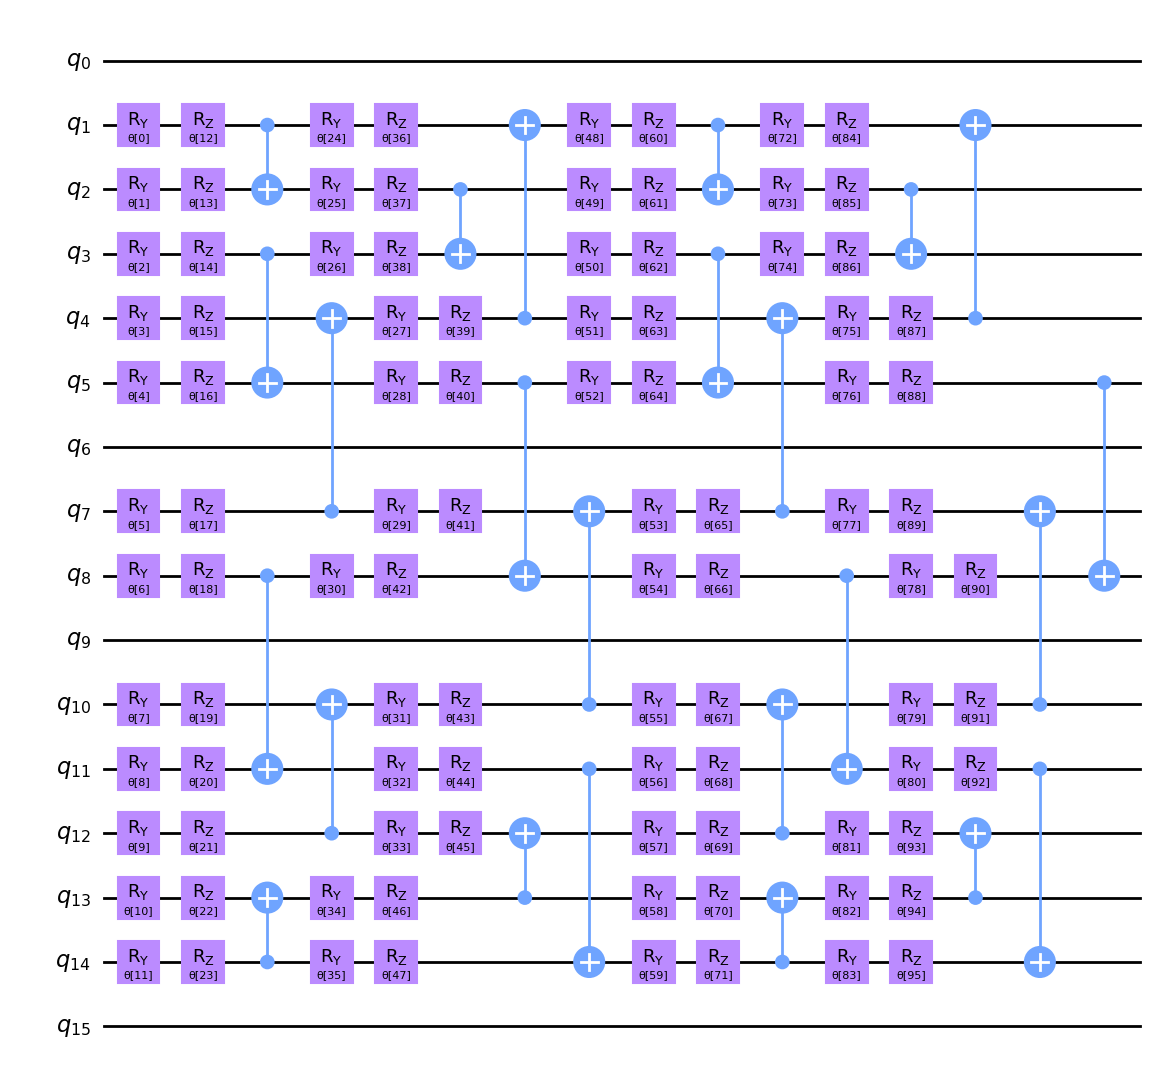

In [2]:
from kagomevqe import GuadalupeExpressibleJosephsonSampler
joe = GuadalupeExpressibleJosephsonSampler()
joe.draw('mpl')


## Results

I have had zero fully successful runs on Guadalupe. Even those that started fine have all errored out sometime during optimization. I had 20 guadalupe jobs fail between April 1 and April 10, when I believe a hardware issue was fixed. During that period I started running simulations with the Guadalupe noise model, both on the IBM QASM simulator and locally with Aer.

- On April 14, guadalupe partially ran a BFGS optimization on the rotational symmetry ansatz. It errored after 40 iterations. Interestingly, the best value was iteration 16: **-17.72233333**. This was job cgsp6mlevgbv2i5rjigg.

Here's a plot of that session.

![Guadalupe aborted run](04-14-22-58-19+0000-fig-values.png)


Best results so far with noisy simulations:

- When using the simple rotational symmetry ansatz at the top of this notebook, noisy simulations typically result in values around -16, sometimes as low as **-16.4758333333333** as in IBM QASM simulator session cgqqrgc5firqikfnuki0 using the `L_BFGS_B` optimizer, which ran for about 20 hours.
- On April 13, I had one noisy Aer simulation that reached **-14.890625**. This one used Rotosolve only (no gate modification) on the expressible Josephson sampler ansatz. It ran for 19.4 hours on a 128 vCPU cloud VM.
- Also on April 13, another simulation reached a similar value: **-14.8203125**. It used Rotoselect (switching to Rotosolve after some iterations) and the Josephson sampler ansatz. It ran for 13.2 hours on that same HPC machine.

My source code is available at https://github.com/towynlin/kagome-vqe. Sometime soon after OSP22 closes, I plan to contribute various pull requests to qiskit, qiskit nature, qiskit ionq, or others as appropriate.

The easiest way to run my experiment, on guadalupe or anywhere else, is to clone that repo, set up the python 3.10 virtual environment per the readme, and then to run it on the command line, for example:

`python -m kagomevqe --backend guadalupe`

That will run Rotoselect on the Josephson sampler ansatz.


In [1]:
import qiskit.tools.jupyter
%qiskit_version_table